### Simulation of a circuit: compare ideal simulator with the fake backend FakeVigoV2
We define a circuit first and simulate its execution with the ideal simulator AerSimulator.

Then we simulate the circuit execution on FakeVigoV2 that models the historical IBM Vigo 5 qubit device.

To this purpose we transpile the circuit to show what it will look like in the native gate set of the target IBM Quantum device.

Furthermore we build a custom simulation introducing a specific error model.

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
# Simulator backend
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
                              pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit_ibm_runtime.fake_provider import FakeVigoV2

### Circuit definition

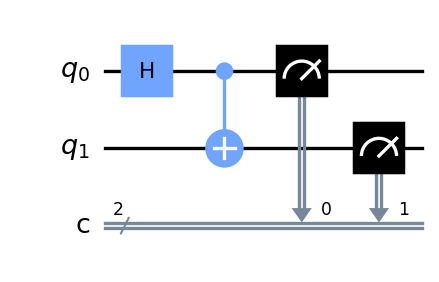

In [2]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure([0, 1], [0, 1])
circ.draw(output='mpl',style='clifford', scale=1.2)

### Run and get counts

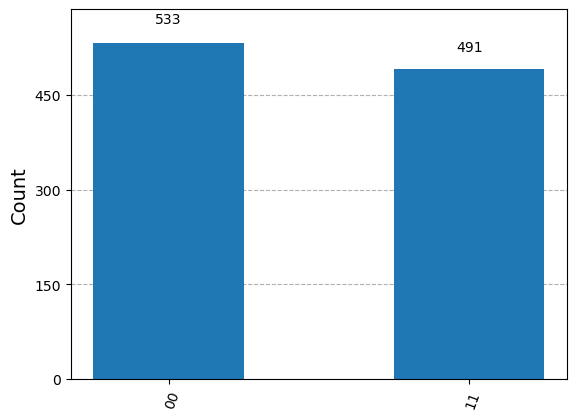

In [3]:
idealSim = AerSimulator()
result_ideal = idealSim.run(circ, shots=1024).result()
ideal_counts = result_ideal.get_counts(circ)
plot_histogram(ideal_counts)

### Transpile the circuit and simulate its execution with FakeVigoV2

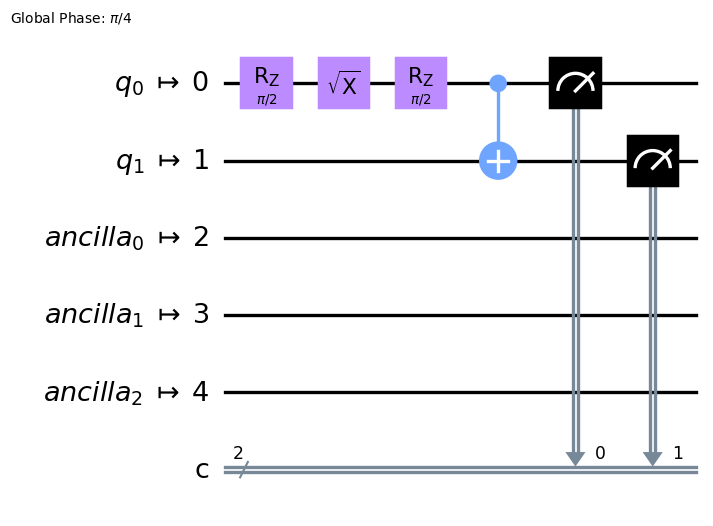

In [4]:
Vigo5Sim = AerSimulator.from_backend(FakeVigoV2())
transpiledCircVigo5 = transpile(circ, Vigo5Sim)
transpiledCircVigo5.draw(output='mpl',style='clifford', scale=1.2)

### Run and get counts

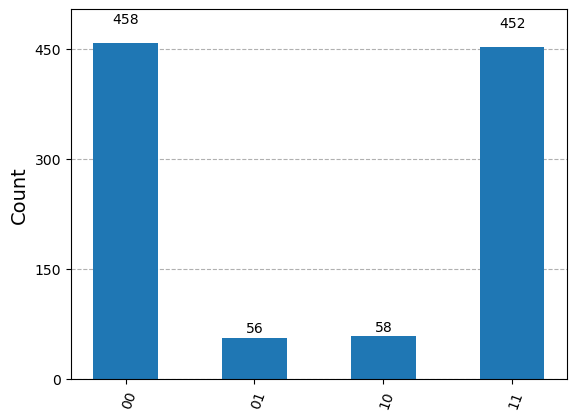

In [5]:
resultVigo5 = Vigo5Sim.run(transpiledCircVigo5, shots=1024).result()
Vigo5_counts=resultVigo5.get_counts(circ)
plot_histogram(Vigo5_counts)

We observe a behavior different from the ideal one, in fact we have non-zero probability of having as output 01 and 10.

### Custom simulation with an error 
Please refer to <a href="https://docs.quantum.ibm.com/api/qiskit/0.19/aer_noise">IBM documentation</a> for a detaild explanation of noise modeling in qiskit aer.

### Error parameters definition 

In [6]:
# Error probability parameter
pReset = 0
pMeas = 0
pSingleGate = 0.1

# QuantumError objects
errorReset = pauli_error([('X', pReset), ('I', 1 - pReset)])
errorMeas = pauli_error([('X', pMeas), ('I', 1 - pMeas)])
errorSingleGate = pauli_error([('X', pSingleGate), ('I', 1 - pSingleGate)])
errorDoubleGate = errorSingleGate.tensor(errorSingleGate)

# Define the error model
noiseModel = NoiseModel()
noiseModel.add_all_qubit_quantum_error(errorReset, "reset")
noiseModel.add_all_qubit_quantum_error(errorMeas, "measure")
noiseModel.add_all_qubit_quantum_error(errorSingleGate, ["u1", "u2", "u3"])
noiseModel.add_all_qubit_quantum_error(errorDoubleGate, ["cx"])

### Noise backend definition

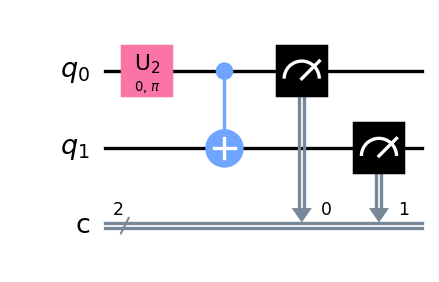

In [7]:
noisySim = AerSimulator(noise_model=noiseModel)
transpiledCircNoisySim = transpile(circ, noisySim)
transpiledCircNoisySim.draw(output='mpl',style='clifford', scale=1.2)

### Run and get counts

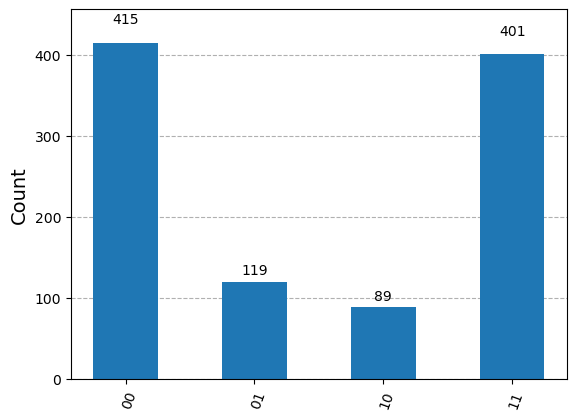

In [8]:
resultNoisySim = noisySim.run(transpiledCircNoisySim).result()
countsNoisySim = resultNoisySim.get_counts(0)
plot_histogram(countsNoisySim)

Changing parameters we can observe how change the observed errors with respect to ideal case.